# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-pack

## Configurations

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [6]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

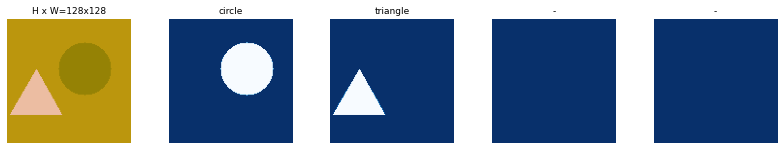

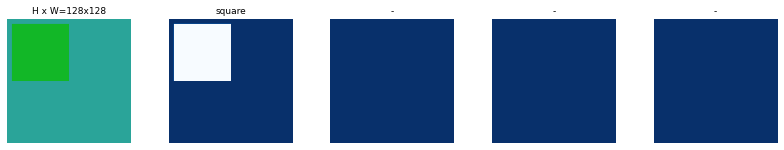

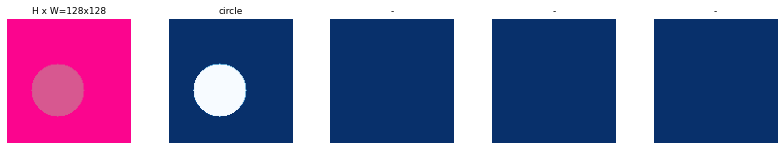

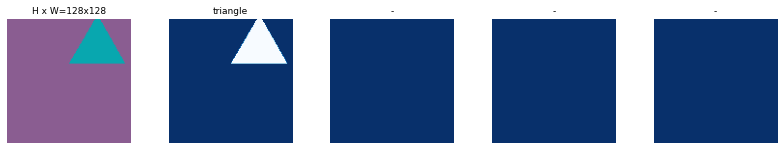

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [12]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\hpdk00~1\appdata\local\temp\pip-req-build-_bcxj9zf
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py): started

  Running command git clone --filter=blob:none -q https://github.com/philferriere/cocoapi.git 'C:\Users\HPDK00~1\AppData\Local\Temp\pip-req-build-_bcxj9zf'



  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-win_amd64.whl size=88809 sha256=9ec30ac34e9345814c31f4de0122632fb978e3d6d521a98a36f19a3e94ea6c3c
  Stored in directory: C:\Users\HPDK00~1\AppData\Local\Temp\pip-ephem-wheel-cache-p6and5j4\wheels\b9\4e\44\7b76fc7329ff952a523b8b7dfa674a02b71ae92de8f4eb96a6
Successfully built pycocotools


In [9]:
!pip uninstall h5py

^C


In [11]:
!pip install h5py==2.10 --user

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: F:\BFL\Mask_RCNN-master-tf1\Mask_RCNN-master\logs\shapes20240305T2100\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  1/100 [..............................] - ETA: 2778s - loss: 10.4356 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 2.3463 - mrcnn_class_loss: 4.5039 - mrcnn_bbox_loss: 2.0411 - mrcnn_mask_loss: 1.4967

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  2/100 [..............................] - ETA: 1446s - loss: 9.2106 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.9851 - mrcnn_class_loss: 3.9414 - mrcnn_bbox_loss: 1.9738 - mrcnn_mask_loss: 1.2578 

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  3/100 [..............................] - ETA: 996s - loss: 8.2969 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.9948 - mrcnn_class_loss: 3.1150 - mrcnn_bbox_loss: 1.8991 - mrcnn_mask_loss: 1.2315 

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  4/100 [>.............................] - ETA: 774s - loss: 7.7195 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 2.1155 - mrcnn_class_loss: 2.5295 - mrcnn_bbox_loss: 1.7515 - mrcnn_mask_loss: 1.2547

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  5/100 [>.............................] - ETA: 639s - loss: 7.2821 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 2.0235 - mrcnn_class_loss: 2.1520 - mrcnn_bbox_loss: 1.6591 - mrcnn_mask_loss: 1.3795

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  6/100 [>.............................] - ETA: 555s - loss: 6.8659 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.8747 - mrcnn_class_loss: 1.9887 - mrcnn_bbox_loss: 1.6519 - mrcnn_mask_loss: 1.2808

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  7/100 [=>............................] - ETA: 490s - loss: 6.5473 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.8138 - mrcnn_class_loss: 1.8341 - mrcnn_bbox_loss: 1.5919 - mrcnn_mask_loss: 1.2364

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  8/100 [=>............................] - ETA: 441s - loss: 6.4365 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.8171 - mrcnn_class_loss: 1.7940 - mrcnn_bbox_loss: 1.5527 - mrcnn_mask_loss: 1.1961

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  9/100 [=>............................] - ETA: 402s - loss: 6.2629 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.7946 - mrcnn_class_loss: 1.7493 - mrcnn_bbox_loss: 1.4836 - mrcnn_mask_loss: 1.1602

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 10/100 [==>...........................] - ETA: 373s - loss: 5.9677 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.6936 - mrcnn_class_loss: 1.6382 - mrcnn_bbox_loss: 1.4301 - mrcnn_mask_loss: 1.1302

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 11/100 [==>...........................] - ETA: 346s - loss: 5.7779 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.6785 - mrcnn_class_loss: 1.5607 - mrcnn_bbox_loss: 1.3690 - mrcnn_mask_loss: 1.0945

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 12/100 [==>...........................] - ETA: 323s - loss: 5.6122 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.6447 - mrcnn_class_loss: 1.5012 - mrcnn_bbox_loss: 1.3248 - mrcnn_mask_loss: 1.0657

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 13/100 [==>...........................] - ETA: 303s - loss: 5.4510 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.5769 - mrcnn_class_loss: 1.4626 - mrcnn_bbox_loss: 1.2933 - mrcnn_mask_loss: 1.0422

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 14/100 [===>..........................] - ETA: 287s - loss: 5.3014 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.5319 - mrcnn_class_loss: 1.4211 - mrcnn_bbox_loss: 1.2528 - mrcnn_mask_loss: 1.0207

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 15/100 [===>..........................] - ETA: 272s - loss: 5.1631 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.4834 - mrcnn_class_loss: 1.3826 - mrcnn_bbox_loss: 1.2225 - mrcnn_mask_loss: 1.0003

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 16/100 [===>..........................] - ETA: 261s - loss: 4.9927 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.4222 - mrcnn_class_loss: 1.3282 - mrcnn_bbox_loss: 1.1880 - mrcnn_mask_loss: 0.9809

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 17/100 [====>.........................] - ETA: 251s - loss: 4.8388 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.3611 - mrcnn_class_loss: 1.2774 - mrcnn_bbox_loss: 1.1652 - mrcnn_mask_loss: 0.9622

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 18/100 [====>.........................] - ETA: 241s - loss: 4.7179 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3223 - mrcnn_class_loss: 1.2317 - mrcnn_bbox_loss: 1.1473 - mrcnn_mask_loss: 0.9440

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 19/100 [====>.........................] - ETA: 232s - loss: 4.6446 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.3099 - mrcnn_class_loss: 1.1960 - mrcnn_bbox_loss: 1.1349 - mrcnn_mask_loss: 0.9295

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 20/100 [=====>........................] - ETA: 224s - loss: 4.5353 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.2732 - mrcnn_class_loss: 1.1581 - mrcnn_bbox_loss: 1.1121 - mrcnn_mask_loss: 0.9178

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 21/100 [=====>........................] - ETA: 217s - loss: 4.4698 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.2672 - mrcnn_class_loss: 1.1260 - mrcnn_bbox_loss: 1.0935 - mrcnn_mask_loss: 0.9081

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 22/100 [=====>........................] - ETA: 209s - loss: 4.4514 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.3020 - mrcnn_class_loss: 1.1058 - mrcnn_bbox_loss: 1.0731 - mrcnn_mask_loss: 0.8948

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 23/100 [=====>........................] - ETA: 202s - loss: 4.3721 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.2870 - mrcnn_class_loss: 1.0749 - mrcnn_bbox_loss: 1.0517 - mrcnn_mask_loss: 0.8844

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 24/100 [======>.......................] - ETA: 195s - loss: 4.2976 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.2620 - mrcnn_class_loss: 1.0505 - mrcnn_bbox_loss: 1.0371 - mrcnn_mask_loss: 0.8753

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 25/100 [======>.......................] - ETA: 189s - loss: 4.2211 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.2330 - mrcnn_class_loss: 1.0297 - mrcnn_bbox_loss: 1.0216 - mrcnn_mask_loss: 0.8643

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 26/100 [======>.......................] - ETA: 183s - loss: 4.1399 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.2168 - mrcnn_class_loss: 1.0005 - mrcnn_bbox_loss: 0.9985 - mrcnn_mask_loss: 0.8532

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 27/100 [=======>......................] - ETA: 175s - loss: 4.0760 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.1932 - mrcnn_class_loss: 0.9830 - mrcnn_bbox_loss: 0.9868 - mrcnn_mask_loss: 0.8433

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 28/100 [=======>......................] - ETA: 168s - loss: 4.0144 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.1791 - mrcnn_class_loss: 0.9644 - mrcnn_bbox_loss: 0.9694 - mrcnn_mask_loss: 0.8325

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 29/100 [=======>......................] - ETA: 162s - loss: 3.9408 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.1587 - mrcnn_class_loss: 0.9407 - mrcnn_bbox_loss: 0.9522 - mrcnn_mask_loss: 0.8214

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 30/100 [========>.....................] - ETA: 156s - loss: 3.8696 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.1368 - mrcnn_class_loss: 0.9190 - mrcnn_bbox_loss: 0.9353 - mrcnn_mask_loss: 0.8114

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 31/100 [========>.....................] - ETA: 150s - loss: 3.8129 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.1190 - mrcnn_class_loss: 0.9021 - mrcnn_bbox_loss: 0.9216 - mrcnn_mask_loss: 0.8037

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 32/100 [========>.....................] - ETA: 144s - loss: 3.7454 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.0966 - mrcnn_class_loss: 0.8832 - mrcnn_bbox_loss: 0.9065 - mrcnn_mask_loss: 0.7941

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 33/100 [========>.....................] - ETA: 139s - loss: 3.6849 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.0782 - mrcnn_class_loss: 0.8643 - mrcnn_bbox_loss: 0.8940 - mrcnn_mask_loss: 0.7845

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 34/100 [=========>....................] - ETA: 134s - loss: 3.6257 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.0619 - mrcnn_class_loss: 0.8456 - mrcnn_bbox_loss: 0.8788 - mrcnn_mask_loss: 0.7765

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 35/100 [=========>....................] - ETA: 130s - loss: 3.5727 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.0460 - mrcnn_class_loss: 0.8307 - mrcnn_bbox_loss: 0.8655 - mrcnn_mask_loss: 0.7686

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 36/100 [=========>....................] - ETA: 125s - loss: 3.5231 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.0320 - mrcnn_class_loss: 0.8146 - mrcnn_bbox_loss: 0.8552 - mrcnn_mask_loss: 0.7602

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 37/100 [==========>...................] - ETA: 121s - loss: 3.4810 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.0183 - mrcnn_class_loss: 0.8042 - mrcnn_bbox_loss: 0.8437 - mrcnn_mask_loss: 0.7545

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 38/100 [==========>...................] - ETA: 117s - loss: 3.4384 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.0067 - mrcnn_class_loss: 0.7923 - mrcnn_bbox_loss: 0.8316 - mrcnn_mask_loss: 0.7480

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 39/100 [==========>...................] - ETA: 113s - loss: 3.3871 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.9883 - mrcnn_class_loss: 0.7792 - mrcnn_bbox_loss: 0.8203 - mrcnn_mask_loss: 0.7406

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 40/100 [===========>..................] - ETA: 109s - loss: 3.3509 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.9784 - mrcnn_class_loss: 0.7692 - mrcnn_bbox_loss: 0.8103 - mrcnn_mask_loss: 0.7350

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 41/100 [===========>..................] - ETA: 105s - loss: 3.3122 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 0.9734 - mrcnn_class_loss: 0.7572 - mrcnn_bbox_loss: 0.7968 - mrcnn_mask_loss: 0.7270

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 42/100 [===========>..................] - ETA: 102s - loss: 3.2763 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 0.9628 - mrcnn_class_loss: 0.7473 - mrcnn_bbox_loss: 0.7881 - mrcnn_mask_loss: 0.7207

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 43/100 [===========>..................] - ETA: 98s - loss: 3.2317 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.9498 - mrcnn_class_loss: 0.7346 - mrcnn_bbox_loss: 0.7770 - mrcnn_mask_loss: 0.7137 

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 44/100 [============>.................] - ETA: 95s - loss: 3.1965 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 0.9382 - mrcnn_class_loss: 0.7248 - mrcnn_bbox_loss: 0.7693 - mrcnn_mask_loss: 0.7083

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 45/100 [============>.................] - ETA: 92s - loss: 3.1683 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 0.9383 - mrcnn_class_loss: 0.7130 - mrcnn_bbox_loss: 0.7596 - mrcnn_mask_loss: 0.7019

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 46/100 [============>.................] - ETA: 89s - loss: 3.1328 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 0.9322 - mrcnn_class_loss: 0.7008 - mrcnn_bbox_loss: 0.7492 - mrcnn_mask_loss: 0.6957

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 47/100 [=============>................] - ETA: 86s - loss: 3.1002 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.9200 - mrcnn_class_loss: 0.6934 - mrcnn_bbox_loss: 0.7422 - mrcnn_mask_loss: 0.6906

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 48/100 [=============>................] - ETA: 83s - loss: 3.0693 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.9080 - mrcnn_class_loss: 0.6884 - mrcnn_bbox_loss: 0.7339 - mrcnn_mask_loss: 0.6857

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 49/100 [=============>................] - ETA: 80s - loss: 3.0389 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.8998 - mrcnn_class_loss: 0.6793 - mrcnn_bbox_loss: 0.7278 - mrcnn_mask_loss: 0.6794

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 50/100 [==============>...............] - ETA: 78s - loss: 3.0013 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.8924 - mrcnn_class_loss: 0.6672 - mrcnn_bbox_loss: 0.7169 - mrcnn_mask_loss: 0.6727

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 51/100 [==============>...............] - ETA: 75s - loss: 2.9687 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.8832 - mrcnn_class_loss: 0.6578 - mrcnn_bbox_loss: 0.7091 - mrcnn_mask_loss: 0.6672

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 52/100 [==============>...............] - ETA: 73s - loss: 2.9367 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.6519 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.6625

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 53/100 [==============>...............] - ETA: 70s - loss: 2.9069 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.8611 - mrcnn_class_loss: 0.6451 - mrcnn_bbox_loss: 0.6927 - mrcnn_mask_loss: 0.6580

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 54/100 [===============>..............] - ETA: 68s - loss: 2.8745 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.8502 - mrcnn_class_loss: 0.6369 - mrcnn_bbox_loss: 0.6851 - mrcnn_mask_loss: 0.6532

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 55/100 [===============>..............] - ETA: 66s - loss: 2.8426 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.8423 - mrcnn_class_loss: 0.6280 - mrcnn_bbox_loss: 0.6766 - mrcnn_mask_loss: 0.6472

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 56/100 [===============>..............] - ETA: 63s - loss: 2.8221 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.8378 - mrcnn_class_loss: 0.6215 - mrcnn_bbox_loss: 0.6721 - mrcnn_mask_loss: 0.6420

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 57/100 [================>.............] - ETA: 61s - loss: 2.7950 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.8301 - mrcnn_class_loss: 0.6143 - mrcnn_bbox_loss: 0.6657 - mrcnn_mask_loss: 0.6370

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 58/100 [================>.............] - ETA: 59s - loss: 2.7683 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.8237 - mrcnn_class_loss: 0.6067 - mrcnn_bbox_loss: 0.6586 - mrcnn_mask_loss: 0.6319

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 59/100 [================>.............] - ETA: 57s - loss: 2.7392 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.8162 - mrcnn_class_loss: 0.5992 - mrcnn_bbox_loss: 0.6506 - mrcnn_mask_loss: 0.6263

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 60/100 [=================>............] - ETA: 55s - loss: 2.7111 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.8088 - mrcnn_class_loss: 0.5916 - mrcnn_bbox_loss: 0.6436 - mrcnn_mask_loss: 0.6207

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 61/100 [=================>............] - ETA: 53s - loss: 2.6825 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.5833 - mrcnn_bbox_loss: 0.6369 - mrcnn_mask_loss: 0.6155

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 62/100 [=================>............] - ETA: 51s - loss: 2.6592 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.7943 - mrcnn_class_loss: 0.5778 - mrcnn_bbox_loss: 0.6309 - mrcnn_mask_loss: 0.6109

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 63/100 [=================>............] - ETA: 50s - loss: 2.6460 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.7956 - mrcnn_class_loss: 0.5734 - mrcnn_bbox_loss: 0.6260 - mrcnn_mask_loss: 0.6061

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 64/100 [==================>...........] - ETA: 48s - loss: 2.6360 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.7979 - mrcnn_class_loss: 0.5692 - mrcnn_bbox_loss: 0.6211 - mrcnn_mask_loss: 0.6033

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 65/100 [==================>...........] - ETA: 46s - loss: 2.6141 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.7920 - mrcnn_class_loss: 0.5631 - mrcnn_bbox_loss: 0.6155 - mrcnn_mask_loss: 0.5993

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 66/100 [==================>...........] - ETA: 45s - loss: 2.5965 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.7896 - mrcnn_class_loss: 0.5584 - mrcnn_bbox_loss: 0.6099 - mrcnn_mask_loss: 0.5946

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 67/100 [===================>..........] - ETA: 43s - loss: 2.5802 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.7860 - mrcnn_class_loss: 0.5547 - mrcnn_bbox_loss: 0.6053 - mrcnn_mask_loss: 0.5906

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 68/100 [===================>..........] - ETA: 41s - loss: 2.5609 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.5499 - mrcnn_bbox_loss: 0.6004 - mrcnn_mask_loss: 0.5866

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 69/100 [===================>..........] - ETA: 40s - loss: 2.5413 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7758 - mrcnn_class_loss: 0.5447 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.5827

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 70/100 [====================>.........] - ETA: 38s - loss: 2.5208 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.7696 - mrcnn_class_loss: 0.5395 - mrcnn_bbox_loss: 0.5901 - mrcnn_mask_loss: 0.5792

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 71/100 [====================>.........] - ETA: 37s - loss: 2.5049 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7667 - mrcnn_class_loss: 0.5353 - mrcnn_bbox_loss: 0.5855 - mrcnn_mask_loss: 0.5754

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 72/100 [====================>.........] - ETA: 35s - loss: 2.4855 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7628 - mrcnn_class_loss: 0.5294 - mrcnn_bbox_loss: 0.5809 - mrcnn_mask_loss: 0.5707

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 73/100 [====================>.........] - ETA: 34s - loss: 2.4664 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7555 - mrcnn_class_loss: 0.5247 - mrcnn_bbox_loss: 0.5776 - mrcnn_mask_loss: 0.5675

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 74/100 [=====================>........] - ETA: 32s - loss: 2.4543 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.7526 - mrcnn_class_loss: 0.5219 - mrcnn_bbox_loss: 0.5748 - mrcnn_mask_loss: 0.5642

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 75/100 [=====================>........] - ETA: 31s - loss: 2.4392 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7499 - mrcnn_class_loss: 0.5175 - mrcnn_bbox_loss: 0.5709 - mrcnn_mask_loss: 0.5603

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 76/100 [=====================>........] - ETA: 29s - loss: 2.4219 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.7454 - mrcnn_class_loss: 0.5128 - mrcnn_bbox_loss: 0.5670 - mrcnn_mask_loss: 0.5564

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 77/100 [======================>.......] - ETA: 28s - loss: 2.4056 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.5085 - mrcnn_bbox_loss: 0.5629 - mrcnn_mask_loss: 0.5529

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 78/100 [======================>.......] - ETA: 27s - loss: 2.3933 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7404 - mrcnn_class_loss: 0.5053 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.5489

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 79/100 [======================>.......] - ETA: 25s - loss: 2.3760 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7341 - mrcnn_class_loss: 0.5010 - mrcnn_bbox_loss: 0.5555 - mrcnn_mask_loss: 0.5458

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 80/100 [=======================>......] - ETA: 24s - loss: 2.3665 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7346 - mrcnn_class_loss: 0.4980 - mrcnn_bbox_loss: 0.5531 - mrcnn_mask_loss: 0.5415

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 81/100 [=======================>......] - ETA: 22s - loss: 2.3501 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7311 - mrcnn_class_loss: 0.4934 - mrcnn_bbox_loss: 0.5493 - mrcnn_mask_loss: 0.5374

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 82/100 [=======================>......] - ETA: 21s - loss: 2.3337 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7282 - mrcnn_class_loss: 0.4883 - mrcnn_bbox_loss: 0.5453 - mrcnn_mask_loss: 0.5333

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 83/100 [=======================>......] - ETA: 20s - loss: 2.3213 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.7262 - mrcnn_class_loss: 0.4845 - mrcnn_bbox_loss: 0.5424 - mrcnn_mask_loss: 0.5297

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 84/100 [========================>.....] - ETA: 19s - loss: 2.3064 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.7235 - mrcnn_class_loss: 0.4807 - mrcnn_bbox_loss: 0.5384 - mrcnn_mask_loss: 0.5256

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 85/100 [========================>.....] - ETA: 17s - loss: 2.2946 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7214 - mrcnn_class_loss: 0.4779 - mrcnn_bbox_loss: 0.5353 - mrcnn_mask_loss: 0.5222

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 86/100 [========================>.....] - ETA: 16s - loss: 2.2810 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.7190 - mrcnn_class_loss: 0.4738 - mrcnn_bbox_loss: 0.5316 - mrcnn_mask_loss: 0.5191

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 87/100 [=========================>....] - ETA: 15s - loss: 2.2670 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.7151 - mrcnn_class_loss: 0.4705 - mrcnn_bbox_loss: 0.5284 - mrcnn_mask_loss: 0.5156

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 88/100 [=========================>....] - ETA: 14s - loss: 2.2500 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.7113 - mrcnn_class_loss: 0.4657 - mrcnn_bbox_loss: 0.5242 - mrcnn_mask_loss: 0.5117

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 89/100 [=========================>....] - ETA: 12s - loss: 2.2360 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.7082 - mrcnn_class_loss: 0.4617 - mrcnn_bbox_loss: 0.5210 - mrcnn_mask_loss: 0.5083

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 90/100 [==========================>...] - ETA: 11s - loss: 2.2179 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.7024 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 0.5167 - mrcnn_mask_loss: 0.5045

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 91/100 [==========================>...] - ETA: 10s - loss: 2.2051 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.6977 - mrcnn_class_loss: 0.4551 - mrcnn_bbox_loss: 0.5137 - mrcnn_mask_loss: 0.5025

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 92/100 [==========================>...] - ETA: 9s - loss: 2.1926 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.6960 - mrcnn_class_loss: 0.4514 - mrcnn_bbox_loss: 0.5103 - mrcnn_mask_loss: 0.4988 

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 93/100 [==========================>...] - ETA: 8s - loss: 2.1800 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6940 - mrcnn_class_loss: 0.4475 - mrcnn_bbox_loss: 0.5068 - mrcnn_mask_loss: 0.4958

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 94/100 [===========================>..] - ETA: 6s - loss: 2.1692 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.4439 - mrcnn_bbox_loss: 0.5044 - mrcnn_mask_loss: 0.4931

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 95/100 [===========================>..] - ETA: 5s - loss: 2.1587 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.6909 - mrcnn_class_loss: 0.4406 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.4897

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 96/100 [===========================>..] - ETA: 4s - loss: 2.1452 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6874 - mrcnn_class_loss: 0.4366 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.4859

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 97/100 [============================>.] - ETA: 3s - loss: 2.1339 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.6849 - mrcnn_class_loss: 0.4332 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.4839

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 98/100 [============================>.] - ETA: 2s - loss: 2.1239 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.4311 - mrcnn_bbox_loss: 0.4944 - mrcnn_mask_loss: 0.4812

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 99/100 [============================>.] - ETA: 1s - loss: 2.1138 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.6803 - mrcnn_class_loss: 0.4286 - mrcnn_bbox_loss: 0.4917 - mrcnn_mask_loss: 0.4785

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\HP DK0045TX\.conda\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

100/100 [==============================] - 160s - loss: 2.1016 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6778 - mrcnn_class_loss: 0.4254 - mrcnn_bbox_loss: 0.4883 - mrcnn_mask_loss: 0.4755 - val_loss: 1.0445 - val_rpn_class_loss: 0.0163 - val_rpn_bbox_loss: 0.4789 - val_mrcnn_class_loss: 0.1407 - val_mrcnn_bbox_loss: 0.2314 - val_mrcnn_mask_loss: 0.1772


In [9]:

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [1]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

NameError: name 'ShapesConfig' is not defined

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


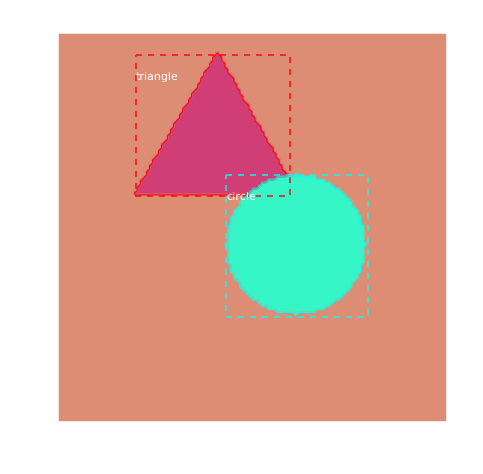

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


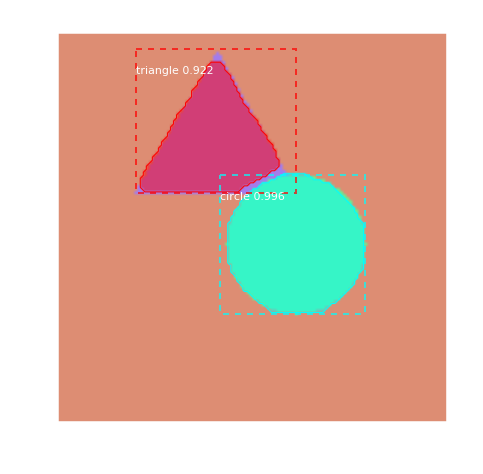

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
